In [1]:
from qiskit import QuantumRegister, QuantumCircuit
import matplotlib

In [2]:
from qiskit_ibm_provider import IBMProvider
IBMProvider.save_account('e6a1a70576aaff96e48f0fff082ea2573162259d53c805b77d38d766e69c3c09739f89a39e8db27b25713b3a9af1d821b30a94789adadb511005d027369ec79d')
provider = IBMProvider()
provider.active_account()
# IBMProvider.delete_account()

{'channel': 'ibm_quantum',
 'token': 'e6a1a70576aaff96e48f0fff082ea2573162259d53c805b77d38d766e69c3c09739f89a39e8db27b25713b3a9af1d821b30a94789adadb511005d027369ec79d',
 'url': 'https://auth.quantum-computing.ibm.com/api',
 'verify': True,
 'instance': 'ibm-q/open/main'}

In [1]:
import numpy as np

# 生成一个5x5的随机数组，每个值大于0
positive_random_array = np.random.uniform(0.1, 10.0, (4, 4))

print(positive_random_array)

[[8.71964918 2.68470061 4.01758933 8.83660166]
 [8.36513678 4.57806876 6.91598966 3.04656776]
 [7.05037345 0.47197036 3.08016333 1.6650888 ]
 [9.8323104  4.78825845 6.26700962 0.24171474]]


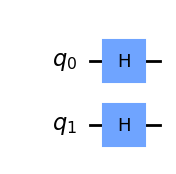

In [16]:
from qiskit import QuantumCircuit
 
# Create a new circuit with two qubits (first argument) and two classical
# bits (second argument)
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
# qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
# qc.cx(0, 1)
qc.h([0, 1])
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

In [7]:
from qiskit.quantum_info import Pauli
 
ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')

In [17]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options, Sampler
 
service = QiskitRuntimeService()
 
# Run on the least-busy backend you have access to
# backend = service.least_busy(simulator=False, operational=True)
backend = 'ibmq_qasm_simulator'
 
options = Options()
options.resilience_level = 1
options.optimization_level = 3
 
# Create an Estimator object
# estimator = Estimator(backend, options=options)
sampler = Sampler(backend, options=options)

# Submit the circuit to Estimator
# job = estimator.run(circuits=[qc]*6, observables=[IZ, IX, ZI, XI, ZZ, XX], shots = 5000)
qc.measure_all()
job = sampler.run(circuits=qc, shots=5)
 
# Once the job is complete, get the result
job.result()

SamplerResult(quasi_dists=[{1: 0.6, 3: 0.4}], metadata=[{'shots': 5, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.01819180000165943}])

In [19]:
print(job.result().quasi_dists[0])
output = job.result().quasi_dists[0]
output = sorted(output.items(), key=lambda item: item[1], reverse=True)
print(output[0][0])
# print(list(output)[0])

{1: 0.6, 3: 0.4}
1


In [1]:
from qiskit import QuantumCircuit, QuantumRegister

q = QuantumRegister(2)
qc_1 = QuantumCircuit(q)
qc_2 = QuantumCircuit(q)

AttributeError: 'str' object has no attribute 'channel'